## Road Centerlines Event and No Traffic

Import and get directory

In [6]:
import arcpy
import os

#Get current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)
#Path for gdb
arcpy.env.workspace = file_path

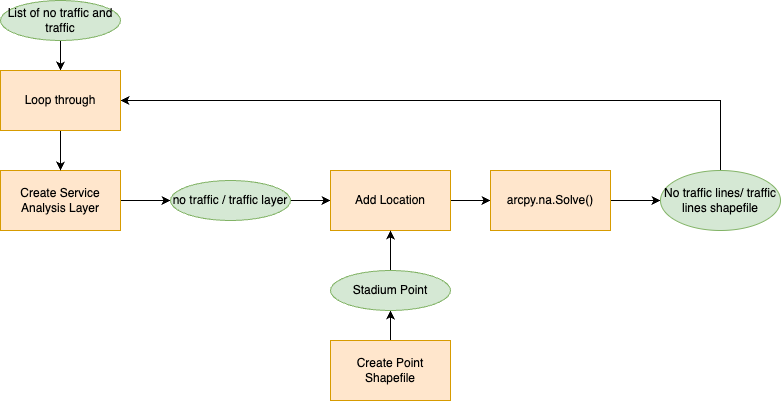
Credits: chat.openai.com

In [7]:
#Define the location for the analysis
facility = (-93.2265955, 44.9754918) #Near stadiums

# Name of the new shapefile
shapefile = "Stadiums.shp"

#Set spatial reference
spatial_ref = arcpy.SpatialReference(4326)

# Create the point shapefile
dest_point = arcpy.CreateFeatureclass_management(arcpy.env.workspace, shapefile, "POINT", spatial_reference=spatial_ref)

# Create a new insert cursor for adding features to the shapefile
with arcpy.da.InsertCursor(shapefile, ["SHAPE@XY"]) as cursor:
    #Add the facility point
    cursor.insertRow([facility])

In [14]:
#Solve traffic layers and export lines
import arcpy

timelist = ["7/12/2023 3:00:00 AM", "10/27/2023 7:45:00 PM"]
for time in timelist:
    if time == "7/12/2023 3:00:00 AM":
        traffic = "no_traffic_layer"
        layer = "No Traffic Base"
        sub = "no_traffic_sublayer"
    elif time == "10/27/2023 7:45:00 PM":
        traffic = "traffic_layer"
        layer = "Traffic Base"
        sub = "traffic_sublayer"
        
    # Make Service Area Analysis Layer
    layer = arcpy.na.MakeServiceAreaAnalysisLayer(
        network_data_source="https://www.arcgis.com/",
        layer_name=traffic,
        travel_mode="Driving Time",
        travel_direction="TO_FACILITIES",
        cutoffs=[10],
        time_of_day=time,  # Correct time format
        time_zone="LOCAL_TIME_AT_LOCATIONS",
        output_type="LINES",
        polygon_detail="STANDARD",
        geometry_at_overlaps="OVERLAP",
        geometry_at_cutoffs="RINGS",
        polygon_trim_distance="100 Meters",
        exclude_sources_from_polygon_generation=None,
        accumulate_attributes=None,
        ignore_invalid_locations="SKIP"
    ).getOutput(0)

    # Adding location to the layer
    arcpy.na.AddLocations(
        in_network_analysis_layer=layer,
        sub_layer="Facilities",
        in_table=dest_point,
        field_mappings="Name # #;CurbApproach # 0;Attr_Minutes # 0;Attr_TravelTime # 0;Attr_Miles # 0;Attr_Kilometers # 0;Attr_TimeAt1KPH # 0;Attr_WalkTime # 0;Attr_TruckMinutes # 0;Attr_TruckTravelTime # 0;Breaks_Minutes # #;Breaks_TravelTime # #;Breaks_Miles # #;Breaks_Kilometers # #;Breaks_TimeAt1KPH # #;Breaks_WalkTime # #;Breaks_TruckMinutes # #;Breaks_TruckTravelTime # #",
        search_tolerance="20000 Meters",
        sort_field=None,
        search_criteria="main.Routing_Streets SHAPE",
        match_type="MATCH_TO_CLOSEST",
        append="APPEND",
        snap_to_position_along_network="NO_SNAP",
        snap_offset="5 Meters",
        exclude_restricted_elements="EXCLUDE",
        search_query=None,
        allow_auto_relocate="ALLOW"
    )
    arcpy.na.Solve(layer)
    out = f"{traffic}_line.shp"
    if time == "7/12/2023 3:00:00 AM":
        no_traffic_sublayer = arcpy.na.GetNASublayer(layer, "SALines")
        arcpy.management.CopyFeatures(no_traffic_sublayer, out)
    elif time == "10/27/2023 7:45:00 PM":
        traffic_sublayer = arcpy.na.GetNASublayer(layer, "SALines")
        arcpy.management.CopyFeatures(traffic_sublayer, out)

## QAQC

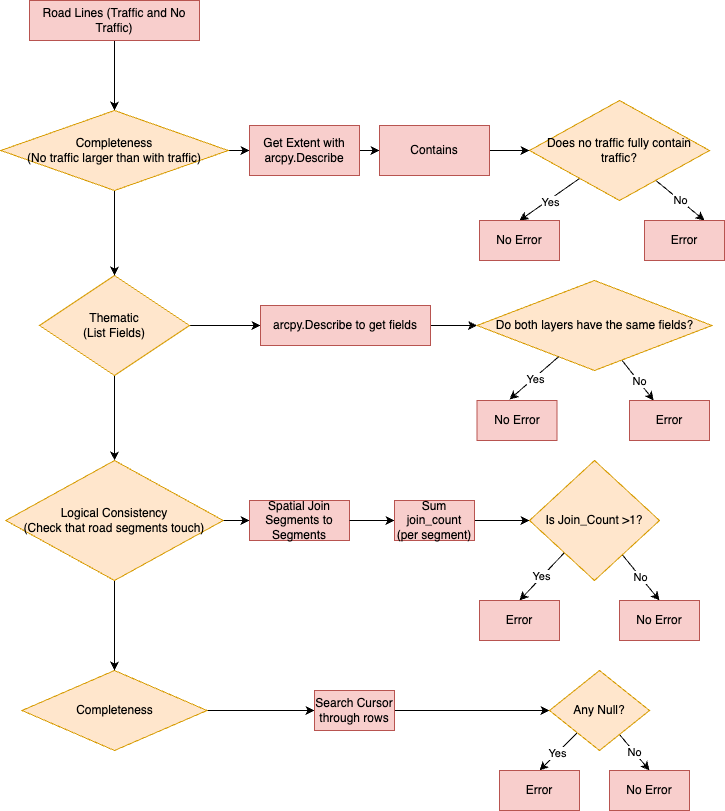

In [17]:
baseline = no_traffic_sublayer
event = traffic_sublayer

#Completeness/Logical Consistency. Check if traffic layer goes farther than no traffic.
# Get the extent of each dataset
baseline_ext = arcpy.Describe(baseline).extent
event_ext = arcpy.Describe(event).extent
describe_baseline = arcpy.Describe(baseline)
describe_event = arcpy.Describe(event)

# Check if baseline encompasses event data
contains = (baseline_ext.contains(event_ext))

# List all field names and compare the fields
baseline_fields = [field.name for field in describe_baseline.fields]
event_fields = [field.name for field in describe_event.fields]
identical_columns = set(baseline_fields) == set(event_fields)

if contains:
    print("Good data: Baseline is larger than traffic.")
else:
    print("Bad data: Baseline is smaller than traffic.")
if identical_columns:
    print("Good data: Both dataset have same columns.")
else:
    print("Bad data: Both datasets do not have the same columns.")

Good data: Baseline is larger than traffic.
Good data: Both dataset have same columns.


In [23]:
#Check if any segments are not touching other segments
datasets = [baseline, event]
for input_data in datasets:
    output_dataset = "temp_data.shp"
    arcpy.analysis.SpatialJoin(
    target_features=input_data,
    join_features=input_data,
    out_feature_class=output_dataset,
    join_operation="JOIN_ONE_TO_MANY",
    join_type="KEEP_ALL",
    match_option="INTERSECT",
    search_radius=None,
    distance_field_name="",
    match_fields=None
    )
    
    # Summarize the join count by the unique ID
    summary_table = arcpy.CreateUniqueName("JoinCountSummary.csv", arcpy.env.workspace)
    
    arcpy.analysis.Statistics(
    in_table=output_dataset,
    out_table=summary_table,
    statistics_fields="Join_Count SUM",
    case_field="TARGET_FID",
    concatenation_separator=""
    )
    
    # Find features that have a join count sum of 1, meaning no joins to other features
    isolated_segments = [row[0] for row in arcpy.da.SearchCursor(summary_table, ["TARGET_FID"], "SUM_Join_Count = 1")]
    
    # Clean up temp data
    arcpy.Delete_management(output_dataset)
    arcpy.Delete_management(summary_table)
    if input_data == baseline:
        print(f"No traffic dataset isolated segments: {isolated_segments}")
    elif input_data == event:
        print(f"Event traffic dataset isolated segments: {isolated_segments}")

No traffic dataset isolated segments: []
Event traffic dataset isolated segments: []


In [25]:
#Check for missing data or values
datasets = [baseline, event]
check_fields = ["FromCumul_TravelTime", "FromCumul_Kilometers", "ToCumul_TravelTime", "ToCumul_Kilometers"]
for data in datasets:
    if data == baseline:
        name = "No Traffic"
    elif data == event:
        name = "Event Traffic"
    missing_values = {}
    for field in check_fields:
        with arcpy.da.SearchCursor(data, [field]) as cursor:
            for row in cursor:
                if row[0] is None:
                    if field not in missing_values:
                        missing_values[field] = 1
                    else:
                        missing_values[field] += 1
                        
    if not missing_values:
        print(f"Data is good for {name}: No missing values found.")
    else:
        print(f"Data is bad for {name}: Missing values.")

Data is good for No Traffic: No missing values found.
Data is good for Event Traffic: No missing values found.
